<a href="https://colab.research.google.com/github/Atchu167/Main-Project-/blob/main/HR_Attrition_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# STEP 1: Install required packages
!pip install shap openpyxl

In [2]:
# STEP 2: Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import shap
import warnings
warnings.filterwarnings('ignore')

In [3]:
# STEP 3: Load the dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_excel(list(uploaded.keys())[0])

Saving hr_analytics_attrition_dataset.xlsx to hr_analytics_attrition_dataset (1).xlsx


In [4]:
# STEP 4: Basic Info
print("Dataset shape:", df.shape)
print(df.dtypes)
df.head()

Dataset shape: (1000, 10)
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spent_company         int64
Work_accident              int64
promotion_last_5years      int64
department                object
salary                    object
left                       int64
dtype: object


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spent_company,Work_accident,promotion_last_5years,department,salary,left
0,0.18,0.77,2,192,6,0,0,Finance,Low,1
1,0.28,0.83,4,173,8,0,1,Management,Medium,0
2,0.84,0.33,3,219,1,1,0,HR,Medium,0
3,0.71,0.75,3,228,6,0,0,Support,High,1
4,0.67,0.46,2,206,2,1,0,Sales,Low,0


In [6]:
# STEP 5: Data Cleaning & Encoding
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

# Optional: Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spent_company       0
Work_accident            0
promotion_last_5years    0
department               0
salary                   0
left                     0
dtype: int64


In [7]:
print("Available columns:", df.columns.tolist())

Available columns: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spent_company', 'Work_accident', 'promotion_last_5years', 'department', 'salary', 'left']


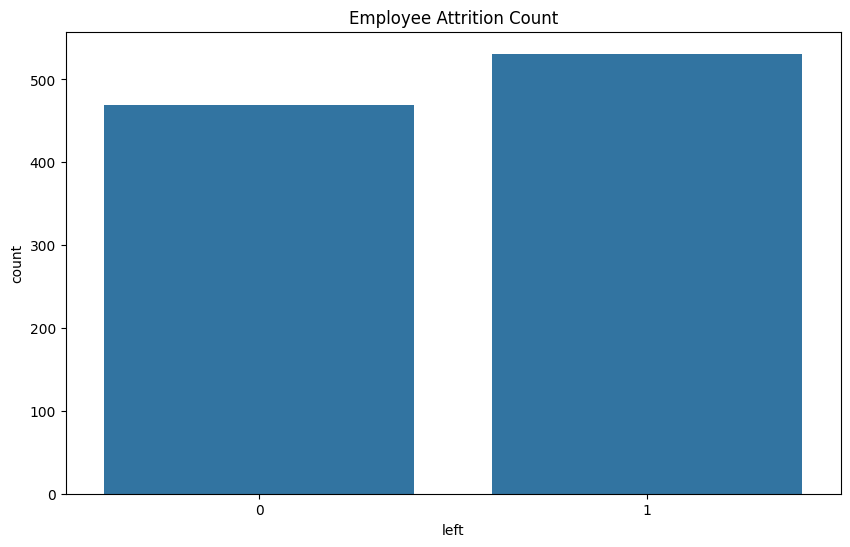

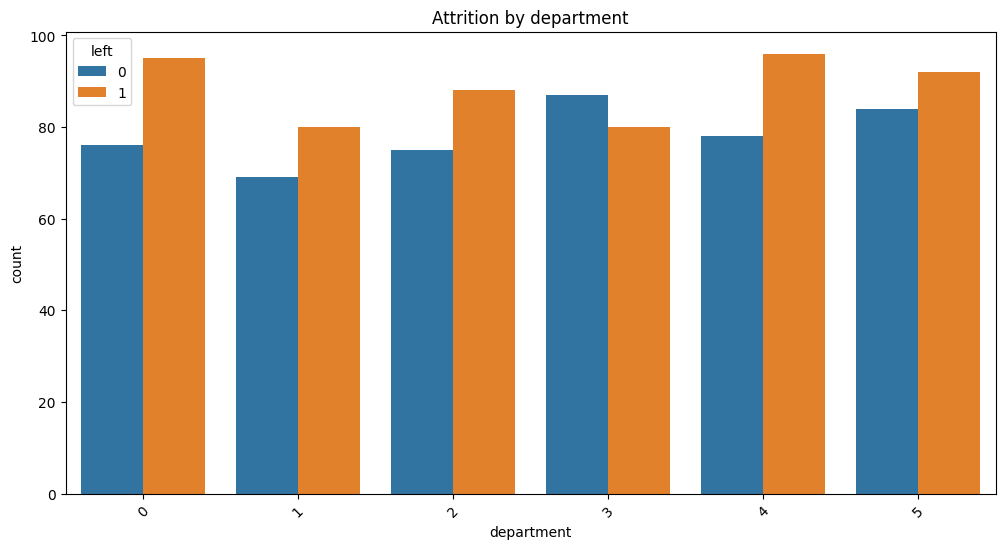

In [8]:
# STEP 6: EDA (Quick Plots)
plt.figure(figsize=(10,6))
sns.countplot(x='left', data=df)
plt.title("Employee Attrition Count")
plt.show()

# department-wise attrition
plt.figure(figsize=(12,6))
sns.countplot(x='department', hue='left', data=df)
plt.title("Attrition by department")
plt.xticks(rotation=45)
plt.show()

# Salary Bands
if 'MonthlyIncome' in df.columns:
    df['IncomeBand'] = pd.qcut(df['MonthlyIncome'], 4, labels=["Low", "Medium", "High", "Very High"])
    plt.figure(figsize=(10,5))
    sns.countplot(x='IncomeBand', hue='Attrition', data=df)
    plt.title("Attrition by Salary Band")
    plt.show()

In [9]:
# STEP 7: Feature & Target Split
X = df.drop(columns=['left'])  # Adjust based on your dataset
y = df['left']

In [10]:
# STEP 8: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# STEP 9: Train Classification Models
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87        91
           1       0.88      0.91      0.90       109

    accuracy                           0.89       200
   macro avg       0.89      0.88      0.88       200
weighted avg       0.89      0.89      0.88       200

Decision Tree Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        91
           1       1.00      0.99      1.00       109

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200

Logistic Accuracy: 0.885
Decision Tree Accuracy: 0.995


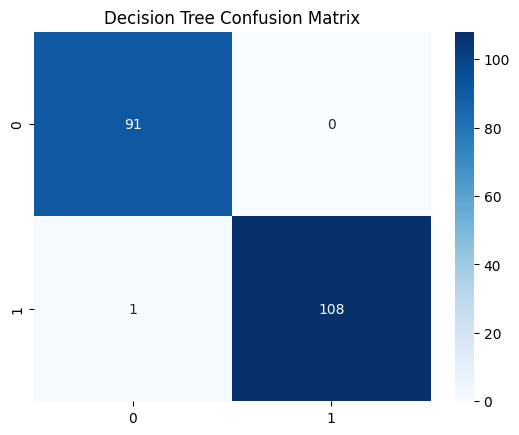

In [12]:
# STEP 10: Evaluation
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))
print("Decision Tree Report:\n", classification_report(y_test, y_pred_dt))

print("Logistic Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree Confusion Matrix")
plt.show()


In [13]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

# Train the Decision Tree model (if not already trained)
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Get feature importances
feature_importance = pd.Series(dt_model.feature_importances_, index=X.columns)

# Get Top 3 important features
top_features = feature_importance.sort_values(ascending=False).head(3)
print("Top 3 Features Influencing Attrition (Decision Tree):")
print(top_features)


Top 3 Features Influencing Attrition (Decision Tree):
time_spent_company       0.468806
promotion_last_5years    0.222661
last_evaluation          0.194858
dtype: float64


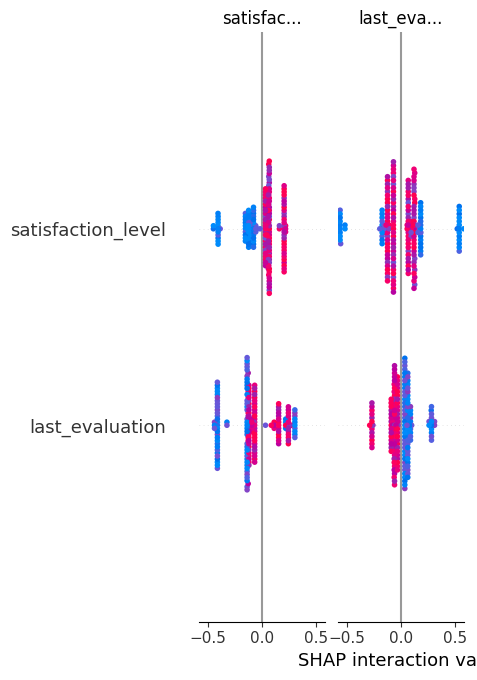

In [17]:
# STEP 11: SHAP Value Analysis
explainer = shap.Explainer(dt, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")